In [1]:
from sklearn.tree import DecisionTreeClassifier
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

In [2]:
churn_model = pd.read_csv("Churn_Modelling.csv")

In [3]:
churn_model.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
churn_model.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)

In [5]:
churn_model['Gender'] = churn_model['Gender'].map({'Male':1,'Female':0})
churn_model['Gender'].value_counts()

1    5457
0    4543
Name: Gender, dtype: int64

In [6]:
# creating a separate data frame to keep a copy of the data from Original data
numerical = churn_model.select_dtypes(include=np.number)
categorical = churn_model.select_dtypes(include=np.object)

In [7]:
categorical_dummies = pd.get_dummies(categorical).astype('uint8')
categorical_dummies.head()

,Geography_France,Geography_Germany,Geography_Spain
0,1,0,0
1,0,0,1
2,1,0,0
3,1,0,0
4,0,0,1


In [8]:
response_variable = numerical['Exited'].copy().astype('uint8').values
numerical = numerical.drop('Exited',axis=1)

In [9]:
numerical = pd.concat([numerical,categorical_dummies],axis=1)
numerical.head(2)

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain
0,619,0,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,0,41,1,83807.86,1,0,1,112542.58,0,0,1


In [10]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(numerical, response_variable, test_size = 1/3, random_state = 0)

In [11]:
from sklearn.preprocessing import StandardScaler
std_sclr = StandardScaler()
X_train = std_sclr.fit_transform(X_train)
X_test = std_sclr.transform(X_test)

In [12]:
from sklearn.ensemble import RandomForestClassifier
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, class_weight='balanced')
rnd_clf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=16, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [13]:
y_pred = rnd_clf.predict(X_test)

In [14]:
# accuracy 
sum(y_test == y_pred) / len(y_test)

0.7813437312537492

In [15]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
print('Confusion matrix:\n', conf_mat)

labels = ['Class 0', 'Class 1']
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('Expected')
plt.show()

Confusion matrix:
 [[2083  563]
 [ 166  522]]


<Figure size 640x480 with 2 Axes>

In [16]:
#Resampling Un-balanced datasets
# Class count
count_class_0, count_class_1 = churn_model.Exited.value_counts()

# Divide by class
df_class_0 = churn_model[churn_model['Exited'] == 0]
df_class_1 = churn_model[churn_model['Exited'] == 1]

In [17]:
count_class_1

2037

Random under-sampling:
1    2037
0    2037
Name: Exited, dtype: int64


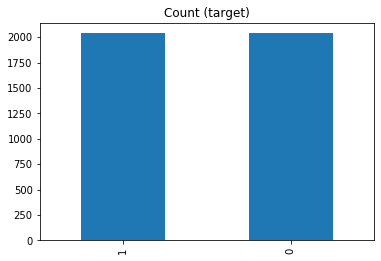

In [18]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.Exited.value_counts())

df_test_under.Exited.value_counts().plot(kind='bar', title='Count (target)');

Now lets import the sklearn cross validation library and do cross validation to see if we can get different accuracy with different train and validation set

In [19]:
from sklearn.model_selection import cross_val_score
cross_val_score(rnd_clf,X_train,y_train,cv=5,scoring='accuracy')

array([0.78335832, 0.77661169, 0.79594899, 0.76744186, 0.79129129])

In [20]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
skfolds = StratifiedKFold(n_splits=5,random_state=42)

In [21]:
for train_index,test_index in skfolds.split(X_train,y_train):
    clone_clf = clone(rnd_clf)
    x_train_folds,y_train_folds = X_train[train_index],y_train[train_index]
    x_test_fold,y_test_fold  = X_train[test_index],y_train[test_index]
    
    clone_clf.fit(x_train_folds,y_train_folds)
    y_pred_fold = clone_clf.predict(x_test_fold)
    n_correct = sum(y_pred_fold == y_test_fold) / len(y_test_fold) 
    print(n_correct)

0.7773613193403298
0.7743628185907047
0.7944486121530383
0.7644411102775694
0.7912912912912913


Lets test the model by creating a dumb classifier

In [22]:
from sklearn.base import BaseEstimator

class NotExited(BaseEstimator):
    def fit(self,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)

In [23]:
notexit = NotExited()
cross_val_score(notexit,x_train_folds,y_train_folds,cv=5,scoring='accuracy')

array([0.79756326, 0.79475164, 0.82099344, 0.78163074, 0.79268293])

Lets balance the data by oversampling the minority class

In [24]:
from imblearn.over_sampling import SMOTE
balance = SMOTE(random_state=42)

x_train_over,y_train_over = balance.fit_sample(x_train_folds,y_train_folds)
print(x_train_over.shape,y_train_over.shape)

(8508, 12) (8508,)


C:\Users\Hammer\Anaconda3\envs\condaenv\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [25]:
print(f"Customers NotExited {sum(y_train_over==0)}")
print(f"Customers Exited {sum(y_train_over==1)}")

Customers NotExited 4254
Customers Exited 4254


In [26]:
rnd_clf.fit(x_train_over,y_train_over)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=16, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=500, n_jobs=-1, oob_score=False,
                       random_state=None, verbose=0, warm_start=False)

In [27]:
y_pred = rnd_clf.predict(x_test_fold)

In [28]:
sum(y_test_fold == y_pred) / len(y_test_fold)

0.7905405405405406

Let's try to see what we get for recall and precision

In [29]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(rnd_clf,x_train_over,y_train_over,cv=5)
np.unique(y_train_pred,return_counts=True)

(array([0, 1], dtype=uint8), array([4333, 4175], dtype=int64))

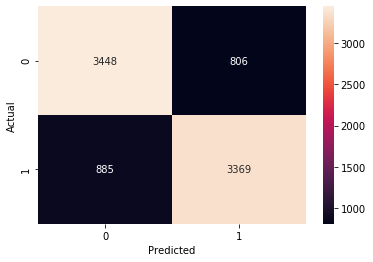

In [30]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_train_over,y_train_pred)

# using seaborn plotting the confusion matrix. 
sns.heatmap(cnf_matrix, annot=True,fmt='.0f')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [31]:
from sklearn.metrics import precision_score,recall_score,f1_score,roc_auc_score

In [32]:
precision_score(y_train_over,y_train_pred)

0.8069461077844311

In [33]:
recall_score(y_train_over,y_train_pred)

0.7919605077574048

In [34]:
f1_score(y_train_over,y_train_pred)

0.7993830822161585

In [35]:
from sklearn.model_selection import cross_val_predict
y_scores = cross_val_predict(rnd_clf,x_train_over,y_train_over,cv=3,method='predict')

In [36]:
roc_auc_score(y_train_over,y_scores)

0.7988951574988246

Hyperparameter search: Fine tune hyperparameters using GridSearchCV

In [37]:
from sklearn.model_selection import GridSearchCV

In [38]:
rnd_clf.get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [57]:
param_grid = {'class_weight':['balanced',None]}


scoring = ['f1','accuracy','precision','recall','roc_auc']

In [58]:
grid_search = GridSearchCV(estimator=rnd_clf,param_grid=param_grid,cv=5,n_jobs=-1,
                           scoring=scoring,refit='f1',
                          return_train_score=True)

In [59]:
%time grid_search.fit(x_train_over,y_train_over)

Wall time: 10.8 s


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=16,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=500, n_jobs=-1,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                    

In [60]:
final_estimator = grid_search.best_estimator_
final_estimator

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=16,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [61]:
grid_search.best_params_

{'class_weight': None}